In [6]:
#Regression following https://www.kaggle.com/chrisbutch/class-1-making-a-bad-chemical-model but using a random forest regressor
#The 'bad' chemical model actually outperforms the one with the better chemical model

import zipfile
import pandas as pd

zf = zipfile.ZipFile("beta_lactamase_CHEMBL29.zip", "r")
df = pd.concat( (pd.read_csv( zf.open(f) ) for f in zf.namelist() ) )

In [7]:
df2 = df[df.pchembl_value.notnull()]
df2=df2.dropna()

In [8]:
df2

,molecule_chembl_id,canonical_smiles,standard_relation,standard_value,standard_units,standard_type,pchembl_value,target_pref_name,bao_label
47,CHEMBL777,O=C(O)[C@H]1/C(=C/CO)O[C@@H]2CC(=O)N21,=,9.0,nM,IC50,8.05,Gil1,assay format
48,CHEMBL404,C[C@]1(Cn2ccnn2)[C@H](C(=O)O)N2C(=O)C[C@H]2S1(...,=,40.0,nM,IC50,7.40,Gil1,assay format
7,CHEMBL777,O=C(O)[C@H]1/C(=C/CO)O[C@@H]2CC(=O)N21,=,70.0,nM,IC50,7.16,Beta-lactamase SCO-1,single protein format
8,CHEMBL403,CC1(C)[C@H](C(=O)O)N2C(=O)C[C@H]2S1(=O)=O,=,6200.0,nM,IC50,5.21,Beta-lactamase SCO-1,single protein format
9,CHEMBL404,C[C@]1(Cn2ccnn2)[C@H](C(=O)O)N2C(=O)C[C@H]2S1(...,=,10.0,nM,IC50,8.00,Beta-lactamase SCO-1,single protein format
...,...,...,...,...,...,...,...,...,...
57,CHEMBL404,C[C@]1(Cn2ccnn2)[C@H](C(=O)O)N2C(=O)C[C@H]2S1(...,=,374.0,nM,IC50,6.43,Carbepenem-hydrolyzing beta-lactamase KPC,assay format
90,CHEMBL404,C[C@]1(Cn2ccnn2)[C@H](C(=O)O)N2C(=O)C[C@H]2S1(...,=,370.0,nM,IC50,6.43,Carbepenem-hydrolyzing beta-lactamase KPC,single protein format
91,CHEMBL777,O=C(O)[C@H]1/C(=C/CO)O[C@@H]2CC(=O)N21,=,10500.0,nM,IC50,4.98,Carbepenem-hydrolyzing beta-lactamase KPC,single protein format
107,CHEMBL777,O=C(O)[C@H]1/C(=C/CO)O[C@@H]2CC(=O)N21,=,11000.0,nM,Ki,4.96,Carbepenem-hydrolyzing beta-lactamase KPC,single protein format


In [9]:
smiles = df2['canonical_smiles']
y=df2['pchembl_value']

In [10]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import pandas as pd
import numpy as np

In [11]:
import re

regex = re.compile('[^a-zA-Z]')
#First parameter is the replacement, second parameter is your input string
regex.sub('', 'ab3d*E')
#Out: 'abdE'

'abdE'

In [12]:
y=np.array(y)
smiles=np.array(smiles)
smiles=[str(i) for i in smiles]
df3=pd.DataFrame({'smiles' : smiles, 'y_vals' : y})

In [13]:
df3['Simple_SMILES']=df3['smiles'].apply(lambda x: regex.sub('',x))

In [14]:
elements=[*set(''.join(df3['Simple_SMILES']))]

In [15]:
for element in elements:
    df3[element]=df3['Simple_SMILES'].apply(lambda x:sum(map(lambda y: 1 if element in y else 0, x)))

In [16]:
X = df3[elements]
y = df3['y_vals']

In [20]:
from sklearn.ensemble import RandomForestRegressor

reg=RandomForestRegressor()
reg.fit(X,y)
pred_chemblval=reg.predict(X)

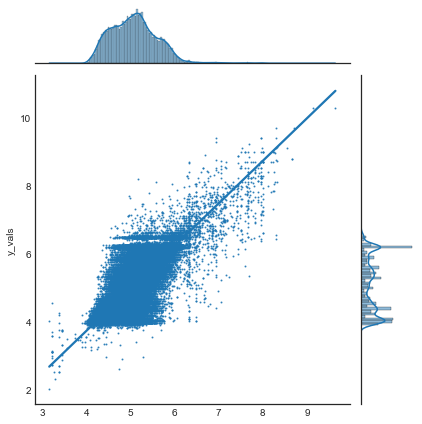

In [21]:
import seaborn as sns
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

sns.jointplot(x=pred_chemblval,
            y=y, 
            kind="reg", 
            scatter_kws={"s": 1});

In [22]:
r2(y,pred_chemblval)

0.6003947565091702

In [15]:
#Clustering from iwatobipen's blog using Morgan fingerprints and Tanimoto Metric

from rdkit import Chem

In [16]:
mols=[Chem.MolFromSmiles(i) for i in smiles] 

In [17]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import DataStructs

for mol in mols:
    AllChem.Compute2DCoords(mol)
X = []
for mol in mols:
    arr = np.zeros((0,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    DataStructs.ConvertToNumpyArray(fp, arr)
    X.append(arr)

In [ ]:
#Reduce dimensions with TSNE and Tanimoto distance metric
from sklearn.manifold import TSNE

def tanimoto_dist(a,b):
    dotprod = np.dot(a,b)
    tc = dotprod / (np.sum(a) + np.sum(b) - dotprod)
    return 1.0-tc

tsne = TSNE(n_components=2, metric=tanimoto_dist)
tsne_X = tsne.fit_transform(X)
print(tsne_X.shape)

/opt/miniconda3/envs/python2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


In [ ]:
plt.scatter(tsne_X.T[0], tsne_X.T[1], color='b')